Imports and Hyperparameters

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# Setting hyperparameters
batch_size, learning_rate, epochs = 64, 0.0005, 30
temperature, alpha = 5.0, 0.7


Data Transformations and Loaders

In [ ]:
# Defining data transformations and loaders
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
full_train_data = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
train_size = int(0.8 * len(full_train_data))
train_data, val_data = random_split(full_train_data, [train_size, len(full_train_data) - train_size])

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(datasets.CIFAR10(root='./data', train=False, transform=transform, download=True),
                         batch_size=batch_size, shuffle=False)


100%|██████████| 170498071/170498071 [00:05<00:00, 29659755.98it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


 Teacher and Student Model Definitions

In [ ]:
# Defining Teacher and Student models
class TeacherNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self._to_linear = self._get_flattened_size()
        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 10)

    def _get_flattened_size(self):
        with torch.no_grad():
            x = torch.rand(1, 3, 32, 32)
            x = self.convs(x)
        return x.numel()

    def forward(self, x):
        x = self.convs(x).view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

class StudentNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self._to_linear = self._get_flattened_size()
        self.fc1 = nn.Linear(self._to_linear, 128)
        self.fc2 = nn.Linear(128, 10)

    def _get_flattened_size(self):
        with torch.no_grad():
            x = torch.rand(1, 3, 32, 32)
            x = self.convs(x)
        return x.numel()

    def forward(self, x):
        x = self.convs(x).view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


Distillation Loss Function

In [ ]:
# Defining the distillation loss
def distillation_loss(student_outputs, teacher_outputs, labels, temperature, alpha):
    soft_targets = F.kl_div(
        F.log_softmax(student_outputs / temperature, dim=1),
        F.softmax(teacher_outputs / temperature, dim=1),
        reduction="batchmean"
    ) * (temperature ** 2)
    hard_targets = F.cross_entropy(student_outputs, labels)
    return alpha * soft_targets + (1 - alpha) * hard_targets


Training and Validation Functions

In [ ]:
# Training and validation functions
def train(model, loader, optimizer, criterion, teacher_model=None, temperature=None, alpha=None):
    model.train()
    total_loss, correct = 0, 0
    for images, labels in loader:
        images, labels = images.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = model(images)
        if teacher_model:
            with torch.no_grad():
                teacher_outputs = teacher_model(images)
            loss = criterion(outputs, teacher_outputs, labels, temperature, alpha)
        else:
            loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (outputs.argmax(dim=1) == labels).sum().item()
    return total_loss / len(loader), correct / len(loader.dataset)

def validate(model, loader, criterion):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            total_loss += criterion(outputs, labels).item()
            correct += (outputs.argmax(dim=1) == labels).sum().item()
    return total_loss / len(loader), correct / len(loader.dataset)


Training and Evaluating Teacher Model

In [ ]:
teacher = TeacherNet().cuda()
teacher_optimizer = optim.Adam(teacher.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

train_acc_teacher, val_acc_teacher = [], []
for epoch in range(epochs):
    train_loss, train_acc = train(teacher, train_loader, teacher_optimizer, criterion)
    val_loss, val_acc = validate(teacher, val_loader, criterion)
    train_acc_teacher.append(train_acc)
    val_acc_teacher.append(val_acc)
    print(f"Epoch {epoch+1}/{epochs}, Teacher Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
torch.save(teacher.state_dict(), 'best_teacher_model.pth')


Epoch 1/30, Teacher Train Acc: 0.4383, Val Acc: 0.5645
Epoch 2/30, Teacher Train Acc: 0.6063, Val Acc: 0.6329
Epoch 3/30, Teacher Train Acc: 0.6696, Val Acc: 0.6867
Epoch 4/30, Teacher Train Acc: 0.7046, Val Acc: 0.7112
Epoch 5/30, Teacher Train Acc: 0.7323, Val Acc: 0.7243
Epoch 6/30, Teacher Train Acc: 0.7504, Val Acc: 0.7285
Epoch 7/30, Teacher Train Acc: 0.7669, Val Acc: 0.7479
Epoch 8/30, Teacher Train Acc: 0.7816, Val Acc: 0.7538
Epoch 9/30, Teacher Train Acc: 0.7903, Val Acc: 0.7568
Epoch 10/30, Teacher Train Acc: 0.8057, Val Acc: 0.7769
Epoch 11/30, Teacher Train Acc: 0.8141, Val Acc: 0.7797
Epoch 12/30, Teacher Train Acc: 0.8235, Val Acc: 0.7756
Epoch 13/30, Teacher Train Acc: 0.8288, Val Acc: 0.7794
Epoch 14/30, Teacher Train Acc: 0.8397, Val Acc: 0.7815
Epoch 15/30, Teacher Train Acc: 0.8434, Val Acc: 0.7945
Epoch 16/30, Teacher Train Acc: 0.8521, Val Acc: 0.7925
Epoch 17/30, Teacher Train Acc: 0.8577, Val Acc: 0.8008
Epoch 18/30, Teacher Train Acc: 0.8648, Val Acc: 0.7954
E

Training and Evaluating Student Model with Distillation

In [ ]:
student = StudentNet().cuda()
student_optimizer = optim.Adam(student.parameters(), lr=learning_rate)

train_acc_student, val_acc_student = [], []
teacher.load_state_dict(torch.load('best_teacher_model.pth'))
teacher.eval()

for epoch in range(epochs):
    train_loss, train_acc = train(student, train_loader, student_optimizer, distillation_loss, teacher, temperature, alpha)
    val_loss, val_acc = validate(student, val_loader, criterion)
    train_acc_student.append(train_acc)
    val_acc_student.append(val_acc)
    print(f"Epoch {epoch+1}/{epochs}, Student Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

torch.save(student.state_dict(), 'best_student_model.pth')


<ipython-input-7-155d9f333c95>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher.load_state_dict(torch.load('best_teacher_model.pth'))


Epoch 1/30, Student Train Acc: 0.3919, Val Acc: 0.4761
Epoch 2/30, Student Train Acc: 0.4948, Val Acc: 0.5334
Epoch 3/30, Student Train Acc: 0.5505, Val Acc: 0.5783
Epoch 4/30, Student Train Acc: 0.5959, Val Acc: 0.6033
Epoch 5/30, Student Train Acc: 0.6192, Val Acc: 0.6287
Epoch 6/30, Student Train Acc: 0.6411, Val Acc: 0.6524
Epoch 7/30, Student Train Acc: 0.6508, Val Acc: 0.6488
Epoch 8/30, Student Train Acc: 0.6655, Val Acc: 0.6722
Epoch 9/30, Student Train Acc: 0.6799, Val Acc: 0.6668
Epoch 10/30, Student Train Acc: 0.6885, Val Acc: 0.6871
Epoch 11/30, Student Train Acc: 0.6967, Val Acc: 0.6948
Epoch 12/30, Student Train Acc: 0.7020, Val Acc: 0.6883
Epoch 13/30, Student Train Acc: 0.7104, Val Acc: 0.7056
Epoch 14/30, Student Train Acc: 0.7144, Val Acc: 0.7079
Epoch 15/30, Student Train Acc: 0.7221, Val Acc: 0.7082
Epoch 16/30, Student Train Acc: 0.7220, Val Acc: 0.7107
Epoch 17/30, Student Train Acc: 0.7301, Val Acc: 0.7167
Epoch 18/30, Student Train Acc: 0.7352, Val Acc: 0.7160
E

Plotting Training and Validation Accuracies

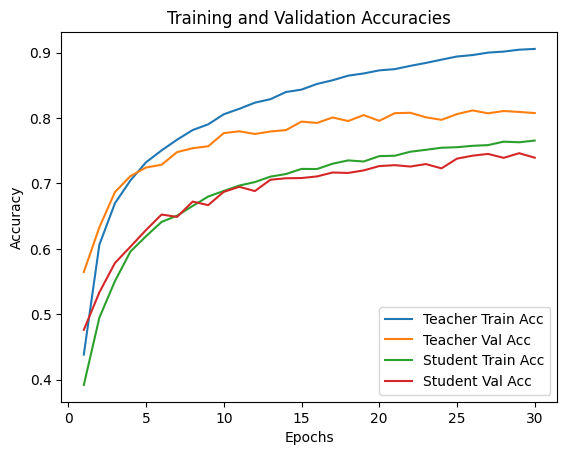

In [ ]:
plt.plot(range(1, epochs + 1), train_acc_teacher, label="Teacher Train Acc")
plt.plot(range(1, epochs + 1), val_acc_teacher, label="Teacher Val Acc")
plt.plot(range(1, epochs + 1), train_acc_student, label="Student Train Acc")
plt.plot(range(1, epochs + 1), val_acc_student, label="Student Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracies")
plt.legend()
plt.show()


Defining Helper Functions for Parameter Counting and Test Evaluation

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def evaluate_model_on_test_data(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total
teacher_params = count_parameters(teacher)
teacher_accuracy = evaluate_model_on_test_data(teacher, test_loader)
print(f'Teacher Model - Parameters: {teacher_params}, Test Accuracy: {teacher_accuracy:.2f}%')

student_params = count_parameters(student)
student_accuracy = evaluate_model_on_test_data(student, test_loader)
print(f'Student Model - Parameters: {student_params}, Test Accuracy: {student_accuracy:.2f}%')


Teacher Model - Parameters: 33930890, Test Accuracy: 80.51%
Student Model - Parameters: 2117962, Test Accuracy: 73.30%


Plotting Parameter and Accuracy Reductions


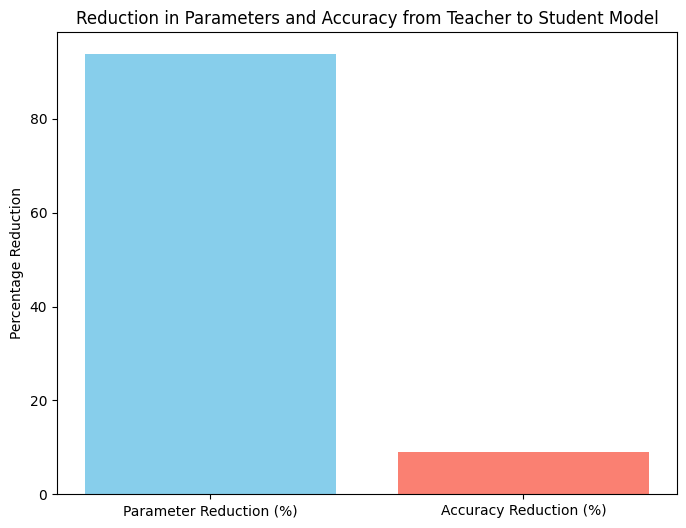

In [ ]:
param_reduction = ((teacher_params - student_params) / teacher_params) * 100
accuracy_reduction = ((teacher_accuracy - student_accuracy) / teacher_accuracy) * 100
plt.figure(figsize=(8, 6))
plt.bar(['Parameter Reduction (%)', 'Accuracy Reduction (%)'], [param_reduction, accuracy_reduction], color=['skyblue', 'salmon'])
plt.ylabel('Percentage Reduction')
plt.title('Reduction in Parameters and Accuracy from Teacher to Student Model')
plt.show()


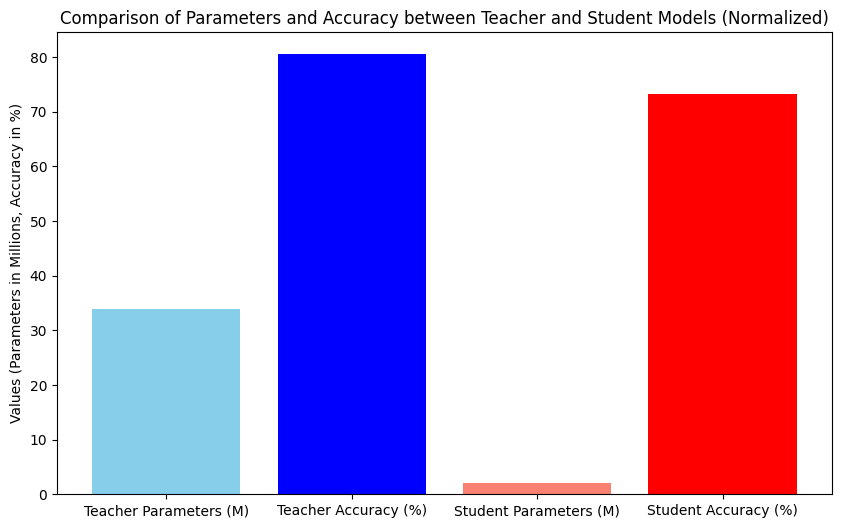

In [ ]:
teacher_params_normalized = teacher_params / 1e6
student_params_normalized = student_params / 1e6
categories = ['Teacher Parameters (M)', 'Teacher Accuracy (%)', 'Student Parameters (M)', 'Student Accuracy (%)']
values = [teacher_params_normalized, teacher_accuracy, student_params_normalized, student_accuracy]
plt.figure(figsize=(10, 6))
plt.bar(categories, values, color=['skyblue', 'blue', 'salmon', 'red'])
plt.ylabel('Values (Parameters in Millions, Accuracy in %)')
plt.title('Comparison of Parameters and Accuracy between Teacher and Student Models (Normalized)')
plt.show()
